In [125]:
import numpy as np
from numpy import sin as Sin
from numpy import cos as Cos
from scipy.optimize import minimize
import random
from tabulate import tabulate

import matplotlib.pyplot as plt

from qiskit import Aer, execute, ClassicalRegister, QuantumRegister, QuantumCircuit, IBMQ

In [2]:
paper_PMNS_dagger_params = (-0.6031, 7.412-4*np.pi, 0.7966,  1.0139, 0.7053, -8.065+4*np.pi)
paper_PMNS_params        = (-0.7053, -1.3599,       0.7966, -1.0139, 0.6031,  2.0125)

In [3]:
def V11(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) - Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [4]:
def V21(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Sin(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [5]:
def V31(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(-(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [6]:
def V41(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [7]:
def V12(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Sin(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [8]:
def V22(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(-(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Sin(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [9]:
def V32(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [10]:
def V42(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) 

In [11]:
def V13(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [12]:
def V23(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [13]:
def V33(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.)) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [14]:
def V43(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [15]:
def V14(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) +\
            Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [16]:
def V24(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
            Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
            Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [17]:
def V34(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [18]:
def V44(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) - \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [19]:
def V(params):
    return np.array([
                     [V11(*params), V12(*params), V13(*params), V14(*params)],
                     [V21(*params), V22(*params), V23(*params), V24(*params)],
                     [V31(*params), V32(*params), V33(*params), V34(*params)],
                     [V41(*params), V42(*params), V43(*params), V44(*params)],
                    ]
                   )

In [20]:
U_PMNS = [[0.821327, 0.149719, 0.55046, 0.],
          [0.305724, 0.699143, -0.646322, 0.],
          [-0.481617, 0.699131, 0.528452, 0.],
          [0., 0., 0., 1.]]

We want to fit the PMNS matrix to matrix V. We want to find some params such that the matrix V is the same as the PMNS Matrix. If we find params such that $$|U_{PMNS}-V(params)| = 0$$ for all rows and columns i and j, these params will be fit to the PMNS Matrix. Now, we must define a function for this likelihood:



Now, we must start with actually evaluating the errors. We must choose a random computational basis to work with, and create some parameters for the PMNS from it. Then, we will use these parameters as the parameters for the gates in our quantum circuit. Our computational basis consists of some n-dimensional vectors, which must have norm of 1 and be orthogonal to eachother.

In [21]:
import sys 
sys.path.append('/Users/pablocastanobasurto/Desktop/Programming/qc_exploration/')
print(sys.path)

['/Users/pablocastanobasurto/Desktop', '/Users/pablocastanobasurto/opt/anaconda3/lib/python38.zip', '/Users/pablocastanobasurto/opt/anaconda3/lib/python3.8', '/Users/pablocastanobasurto/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/pablocastanobasurto/opt/anaconda3/lib/python3.8/site-packages', '/Users/pablocastanobasurto/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/pablocastanobasurto/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/pablocastanobasurto/.ipython', '/Users/pablocastanobasurto/Desktop/Programming/qc_exploration/']


In [30]:
def matrix_likelihood(params, target_matrix):
    # make a box
    if np.any([p>2*np.pi for p in params]):
        value = np.inf
    elif np.any([p<-2*np.pi for p in params]):
        value = np.inf
    else:
        mat   = V(tuple(params))
        value = np.sum([np.abs(np.abs(mat[i,j]-target_matrix[i,j])) for i in range(4)
                                                                    for j in range(4)])
    return value


#We define the functions that we will use to rotate the vectors by some arbitrary angles (thx, thy, thz). 

def x_rotation(thx, vector):
    thx1 = np.radians(thx)
    c, s = np.cos(thx1), np.sin(thx1)
    R1 = [
            [1, 0, 0 ,0], 
            [0, c, -s, 0], 
            [0, s, c, 0], 
            [0, 0, 0, 1]
        ]
    return np.matmul(R1, vector)
    
def y_rotation(thy, vector):
    thy1 = np.radians(thy)
    c, s = np.cos(thy1), np.sin(thy1)
    R2 = [
            [c, 0, -s,0], 
            [0, 1, 0, 0], 
            [s, 0, c, 0],
            [0, 0, 0, 1]
        ]
    return np.matmul(R2, vector)

def z_rotation(thz, vector):
    thz1 = np.radians(thz)
    c, s = np.cos(thz1), np.sin(thz1)
    R3 = [
            [c, -s, 0,0], 
            [s, c, 0, 0], 
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]
    return np.matmul(R3, vector)

#DEFINE A FUNCTION THAT ROTATES A VECTOR BY ARBITRARY THX, THY AND THZ. Then, we will rotate each vector in non_rotated vectors by applying this function to it.            

def full_rotation(thx, thy, thz, vector):
    vector1 = x_rotation(thx, vector)
    vector2 = y_rotation(thy, vector1)
    vector3 = z_rotation(thz, vector2)
    return(vector3)

#DEFINE THE FUNCITONS FOR RUNNING ON THE QC

def run_on_QC(params1, params2):
    from three_neutrino import ThreeNuOscillator
    loee = np.linspace(0, 1200, 21)
    n = 10000
    sim_results = np.zeros((4,len(loee)))
    for i, LE in enumerate(loee):
        tno = ThreeNuOscillator('numu')
        tno.apply_rotation(param=params1)
        tno.propoagate(LE)
        tno.apply_rotation(param=params2)
        tno.measure()
        job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=n)
        counts = job.result().get_counts(tno.qc)
        return(counts)
        #for j, (key, val) in enumerate(sorted(counts.items())):
            #sim_results[j, i] = float(val)/n
        #return(sim_results[j,i])
            
def plot_the_results(simulation_results):
    labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
    cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
    qc_results = np.load('/Users/pablocastanobasurto/Desktop/Programming/qc_exploration/three_neutrino_qc.npy') # Load results from actual quantum computer
    plt.figure(figsize=[10,6])
    for i, (c, lab) in enumerate(zip(cs, labels)):
        plt.scatter(loee, qc_results[i], color=c)
        plt.plot(loee, sim_results[i], label=lab, color=c)
    plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
    plt.xlim(0, 1200)
    plt.ylim(0, 1.4)
    plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
    plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
    plt.show()
    
def make_counts_error(counts, p0_01 = 0.01, p0_10 = 0.02, p1_01 = 0.03, p1_10 = 0.04):
    
    sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
    container = np.full((2, n), np.nan) # premake array which we will fill with our results
    start = 0
    for key, val in counts.items():
        for i in range(val):
            container[:,i+start] = [x for x in str(key)]
        start += val

    rand_ns1 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns2 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns3 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns4 = np.random.rand(n) # Make some random numbers between 0 and 1
    sim_results_error[0] = np.where(rand_ns1>p0_01, container[0], 1-container[0])
    sim_results_error[1] = np.where(rand_ns2>p1_01, container[1], 1-container[1])
    sim_results_error[0] = np.where(rand_ns1>p0_10, container[0], 1-container[0])
    sim_results_error[1] = np.where(rand_ns2>p1_10, container[1], 1-container[1])
    counts_error = {'11':0, '00':0, '01':0, '10':0}
    for entry in sim_results_error.T: # gather things back into a dictionary
        key = str(int(entry[0]))+str(int(entry[1]))
        counts_error[key] += 1
        return counts_error


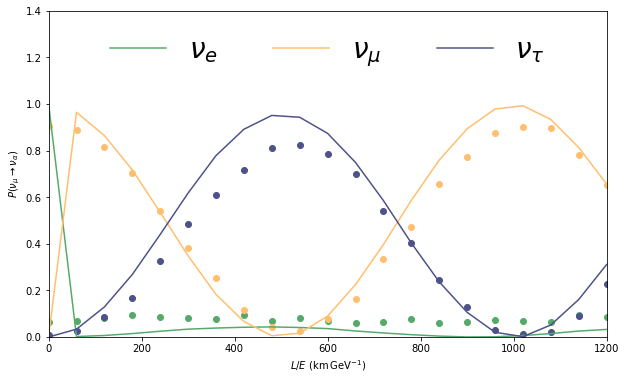

In [34]:
'''from three_neutrino import ThreeNuOscillator

loee = np.linspace(0, 1200, 21)
n = 10000
sim_results = np.zeros((4,len(loee)))
for i, LE in enumerate(loee):
    tno = ThreeNuOscillator('numu')
    tno.apply_rotation(param=paper_PMNS_params)
    tno.propoagate(LE)
    tno.apply_rotation(param=paper_PMNS_dagger_params)
    tno.measure()
    job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=n)
    counts = job.result().get_counts(tno.qc)
    for j, (key, val) in enumerate(sorted(counts.items())):
        sim_results[j, i] = float(val)/n

labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results = np.load('/Users/pablocastanobasurto/Desktop/Programming/qc_exploration/three_neutrino_qc.npy') # Load results from actual quantum computer
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    plt.scatter(loee, qc_results[i], color=c)
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()'''

In [35]:
'''p0 = 0.05
p1 = 0.03

sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
container = np.full((2, n), np.nan) # premake array which we will fill with our results
start = 0
for key, val in counts.items():
    for i in range(val):
        container[:,i+start] = [x for x in str(key)]
    start += val

rand_ns1 = np.random.rand(n) # Make some random numbers between 0 and 1
rand_ns2 = np.random.rand(n) # Make some random numbers between 0 and 1
sim_results_error[0] = np.where(rand_ns1>p0, container[0], 1-container[0])
sim_results_error[1] = np.where(rand_ns2>p1, container[1], 1-container[1])
counts_error = {'11':0, '00':0, '01':0, '10':0}
for entry in sim_results_error.T: # gather things back into a dictionary
    key = str(int(entry[0]))+str(int(entry[1]))
    counts_error[key] += 1
print(counts)
print(counts_error)'''

{'00': 325, '01': 6565, '10': 3110}
{'11': 398, '00': 643, '01': 6060, '10': 2899}


In [138]:
N = 1000
minimal_error_ones = []
list_with_all_percentage_errors = []

for i in range(N):
    
    vector = np.random.random(size=(4)) #define a random vector
    ths = tuple(np.random.rand(3)*360) 
    R_cm = (full_rotation(*ths, [[1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]]))
    R_cf = (np.matmul(np.array(U_PMNS), R_cm)) #find the 'PMNS prime'
    
    #add a smaller for loop here to run the params guesses
    n_guesses = 100
    first_guesses = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
    llhs = [matrix_likelihood(guess, R_cf) for guess in first_guesses] # evaluate likelihood for each guess
    sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
    best_guess = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
    PMNS_fit = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', tol=1e-15, args=R_cf) # run the minimizer starting from the best guess
    PMNS_params = PMNS_fit.x
    PMNS_dagger_params = (-PMNS_params[4],-PMNS_params[5],-PMNS_params[2],-PMNS_params[3],-PMNS_params[0],-PMNS_params[1],)
    #print(r'The best fit parameters for this set of guesses are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(PMNS_params))
    #print(np.log10(np.abs((V(PMNS_dagger_params)-R_cf)/R_cf))) #tells us how good the guesses are
    #print([PMNS_dagger_params])
    #print([PMNS_params])
    #run the QC using these params
    run_on_QC(PMNS_params, PMNS_dagger_params)
    #plot_the_results(sim_results[j,i])
    
    #add the probabilistic flip of errors, probabilities of each bit flip are random
    
    p0_01 = 0.01
    p0_10 = 0.02
    p1_01 = 0.03
    p1_10 = 0.04
    n = (counts['00'] + counts['01'] +counts['10'])
    
    sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
    container = np.full((2, n), np.nan) # premake array which we will fill with our results
    start = 0
    for key, val in counts.items():
        for i in range(val):
            container[:,i+start] = [x for x in str(key)]
        start += val

    rand_ns1 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns2 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns3 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns4 = np.random.rand(n) # Make some random numbers between 0 and 1
    sim_results_error[0] = np.where(rand_ns1>p0_01, container[0], 1-container[0])
    sim_results_error[1] = np.where(rand_ns2>p1_01, container[1], 1-container[1])
    sim_results_error[0] = np.where(rand_ns1>p0_10, container[0], 1-container[0])
    sim_results_error[1] = np.where(rand_ns2>p1_10, container[1], 1-container[1])

    counts_error = {'11':0, '00':0, '01':0, '10':0}
    for entry in sim_results_error.T: # gather things back into a dictionary
        key = str(int(entry[0]))+str(int(entry[1]))
        counts_error[key] += 1
    #print('The number of qubits with each value that we SHOULD have are: ', counts)
    #print('The number of qubits with each value that we HAVE are: ', counts_error)
    #print('The angles we are rotating the computational basis by are: ', ths)
    
    bitflip00= np.abs((counts['00'] - counts_error['00']))
    bitflip01 = np.abs((counts['01'] - counts_error['01']))
    bitflip10 = np.abs((counts['10'] - counts_error['10']))
    bitflip11 = np.abs((0 + counts_error['11']))
    how_far_off = (bitflip00 + bitflip01 + bitflip10 + bitflip11)/float(n)
    Error_Function = [float(ths[0]), float(ths[1]), float(ths[2]), float(how_far_off)] #ADD VECTOR AND PMNS PARAMS HERE
    #print(Error_Function)
    if Error_Function[3] <= 0.095:
        print(Error_Function)#take the ones with small error
        minimal_error_ones.append(Error_Function)
        list_with_all_percentage_errors.append(Error_Function[3])

if len(minimal_error_ones) == 0: 
    print('There were no trials close enough to what we are looking for.')
else:
    #Add something over here that chooses the best out of all the vectors in the error function
    smallest_error = min(list_with_all_percentage_errors)
    print('------------------------')
    print('The smallest error is: ', smallest_error)

    x_rotation_angle_list = []
    y_rotation_angle_list = []
    z_rotation_angle_list = []
    percentage_error_list = []

    for i in minimal_error_ones:
        x_rotation_angle_list.append(i[0])
    for i in minimal_error_ones:
        y_rotation_angle_list.append(i[1])
    for i in minimal_error_ones:
        z_rotation_angle_list.append(i[2])
    for i in minimal_error_ones:
        percentage_error_list.append(i[3])

    print(tabulate([['\033[1m'+'x-rotation-angles'+'\033[0m', x_rotation_angle_list], ['\033[1m'+'y-rotation-angles'+'\033[0m', y_rotation_angle_list], ['\033[1m'+'z-rotation-angles'+'\033[0m', z_rotation_angle_list], ['\033[1m'+'% error'+'\033[0m', percentage_error_list]]))




[259.0146167628177, 75.14805187862505, 65.8861719257784, 0.0928]
[95.26313070940712, 233.558865240681, 168.46663583055187, 0.095]
------------------------
The smallest error is:  0.0928
-----------------  --------------------------------------
x-rotation-angles  [259.0146167628177, 95.26313070940712]
y-rotation-angles  [75.14805187862505, 233.558865240681]
z-rotation-angles  [65.8861719257784, 168.46663583055187]
% error            [0.0928, 0.095]
-----------------  --------------------------------------


In [ ]:
best_result_to_date = [259.0146167628177, 75.14805187862505, 65.8861719257784, 0.0928]

In [139]:
#Add something over here that chooses the best out of all the vectors in the error function
smallest_error = min(list_with_all_percentage_errors)
print('------------------------')
print('The smallest error is: ', smallest_error)
       
x_rotation_angle_list = []
y_rotation_angle_list = []
z_rotation_angle_list = []
percentage_error_list = []

for i in minimal_error_ones:
    x_rotation_angle_list.append(i[0])
for i in minimal_error_ones:
    y_rotation_angle_list.append(i[1])
for i in minimal_error_ones:
    z_rotation_angle_list.append(i[2])
for i in minimal_error_ones:
    percentage_error_list.append(i[3])
    
print(tabulate([['\033[1m'+'x-rotation-angles'+'\033[0m', x_rotation_angle_list], ['\033[1m'+'y-rotation-angles'+'\033[0m', y_rotation_angle_list], ['\033[1m'+'z-rotation-angles'+'\033[0m', z_rotation_angle_list], ['\033[1m'+'% error'+'\033[0m', percentage_error_list]]))


------------------------
The smallest error is:  0.0928
-----------------  --------------------------------------
x-rotation-angles  [259.0146167628177, 95.26313070940712]
y-rotation-angles  [75.14805187862505, 233.558865240681]
z-rotation-angles  [65.8861719257784, 168.46663583055187]
% error            [0.0928, 0.095]
-----------------  --------------------------------------
